In [1]:
#already setup: conda env using python3.12.9
#and "pip install" done for all needed packages - also see pip freeze at the bottom

In [2]:
# Warning control
#import warnings
#warnings.filterwarnings('ignore')

<>:31: SyntaxWarning: invalid escape sequence '\k'
<>:31: SyntaxWarning: invalid escape sequence '\k'
C:\Users\folso\AppData\Local\Temp\ipykernel_64492\1643562593.py:31: SyntaxWarning: invalid escape sequence '\k'
  img = Image.open('.\kobe.jpeg')
c:\ProgramData\anaconda3\envs\vit_gpt_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\ProgramData\anaconda3\envs\vit_gpt_env\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


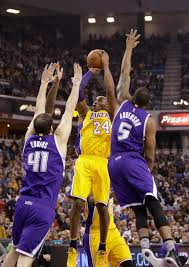

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


(3, 224, 224)


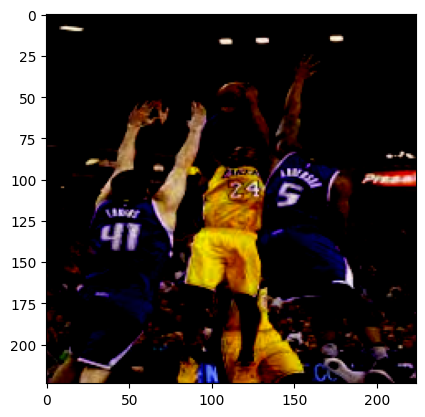

In [ ]:
# Vision Transformer and GPT fine-tuned for an image captioning system
# with this kaggle dataset: https://www.kaggle.com/datasets/adityajn105/flickr8k

from transformers import ViTModel
from transformers import AutoFeatureExtractor #which converts images into tensors

from transformers import VisionEncoderDecoderModel, GPT2TokenizerFast, AutoFeatureExtractor, \
                         AutoTokenizer, TrainingArguments, Trainer

from sklearn.feature_extraction.text import CountVectorizer

from PIL import Image #pip install Pillow
import os

import matplotlib.pyplot as plt
import numpy as np

from datasets import Dataset

import torch
import numpy as np
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize
import pandas as pd

import requests
from io import BytesIO

feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

#img = Image.open('./kobe.jpeg')
img = Image.open('.\kobe.jpeg')
display(img)
print(feature_extractor(img).pixel_values[0].shape)
# (3,224,224) # 3 due to color, 224 due to feature_extractor resized the image

plt.imshow(feature_extractor(img).pixel_values[0].transpose(1, 2, 0))
# original image got (3,224,224)
# .transpose here put the 1st dimension for colors as the last dimension
# .. which was the 0 in (1, 2, 0), as it is 0-based

In [5]:
feature_extractor

ViTFeatureExtractor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
# Load up a pretrained Vision Transformer
# Many weights are innitialized randomly, namely the cross attention weights
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    'google/vit-base-patch16-224-in21k', #224 for image size, in for ImageNet, 21k dataset
    'distilgpt2' #use better/newer gemma3:1b or gemma3:4b instead? #https://huggingface.co/docs/transformers/en/model_doc/gemma3
    # .. NO .. because this small distilgpt2 already took hours to train below
)
#needed this for above (per https://pytorch.org/get-started/locally/):
#pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

#from practical point of view nowadays, this (and others) will be much better for the task here: https://ollama.com/x/llama3.2-vision

print(type(model.encoder))
print(type(model.decoder))

total_params = 0
for param in model.parameters():
    #total_params += numel(param)
    total_params += param.numel()
print(f"Our model has a combined {total_params:,} parameters")

gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('distilgpt2')

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.2.crossattention.c_attn.bias', 'transformer.h.2.crossattention.c_attn.weight', 'transformer.h.2.crossattention.c_proj.bias', 'transformer.h.2.cr

<class 'transformers.models.vit.modeling_vit.ViTModel'>
<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>
Our model has a combined 182,485,248 parameters


In [7]:
model # note "patch embeddings" below, vs text-based transformer's word embeddings

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (inte

In [8]:
#IMAGES_PATH = './flicker_images'
IMAGES_PATH = '.\\flicker_images' #for windows
MIN_CAPTION, MAX_CAPTION = 10, 50

def load_captions_data(filename):
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            if img_name.endswith("jpg"):
                caption = caption.replace(' .', '').strip()
                tokens = caption.strip().split()
                if len(caption) < MIN_CAPTION or len(caption) > MAX_CAPTION:
                    continue
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        return caption_mapping, text_data

# Load the dataset
captions_mapping, text_data = load_captions_data("./Flickr8k.token.txt")

In [9]:
list(captions_mapping.items())[:3] #multiple captions for each image, all are considered correct

[('.\\flicker_images\\1000268201_693b08cb0e.jpg',
  ['A girl going into a wooden building',
   'A little girl climbing into a wooden playhouse',
   'A little girl climbing the stairs to her playhouse']),
 ('.\\flicker_images\\1001773457_577c3a7d70.jpg',
  ['A black dog and a spotted dog are fighting',
   'Two dogs on pavement moving toward each other']),
 ('.\\flicker_images\\1003163366_44323f5815.jpg',
  ['A man lays on a bench while his dog sits by him',
   'A shirtless man lies on a park bench with his dog'])]

In [10]:
normalize = Normalize(
    mean=feature_extractor.image_mean,
    std=feature_extractor.image_std
)

_transforms = Compose(
    [
        RandomResizedCrop(size=(feature_extractor.size['height'], feature_extractor.size['width'])), # Data augmentation. Randomly crop the image, then resize to 224x224
        ToTensor(),                                  # Convert to pytorch tensor
        normalize                                    # normalize pixel values to look like images during pre-training
    ]
)

In [11]:
rows = []

# using multiple captions per image, given data augmentation being used
for path, captions in captions_mapping.items():
    for caption in captions:
        rows.append({'path': path, 'caption': caption})

image_df = pd.DataFrame(rows)

image_dataset = Dataset.from_pandas(image_df)

In [12]:
print(image_df.shape)
print(image_df.head())

(19599, 2)
                                         path  \
0  .\flicker_images\1000268201_693b08cb0e.jpg   
1  .\flicker_images\1000268201_693b08cb0e.jpg   
2  .\flicker_images\1000268201_693b08cb0e.jpg   
3  .\flicker_images\1001773457_577c3a7d70.jpg   
4  .\flicker_images\1001773457_577c3a7d70.jpg   

                                             caption  
0                A girl going into a wooden building  
1     A little girl climbing into a wooden playhouse  
2  A little girl climbing the stairs to her playh...  
3         A black dog and a spotted dog are fighting  
4      Two dogs on pavement moving toward each other  


In [13]:
# this is just for debug purpose
current_directory = os.getcwd()
#print("current directory is:", current_directory)
entries = os.listdir(current_directory)

for entry in entries:
    print(entry)

entries = os.listdir("./flicker_images")

for entry in entries[:10]:
    print(entry)

if "1000268201_693b08cb0e.jpg" in entries:
    print("yes, 1000268201_693b08cb0e.jpg, which will be used later for both fine-tuned and non-fine-tuned models, is in the folder")
else:
    print("no, 1000268201_693b08cb0e.jpg, which will be used later for both fine-tuned and non-fine-tuned models, is NOT in the folder")

.conda
0.26.0
0.26.0'
flicker_images
flicker_images-20250513T184349Z-1-001.zip
Flickr8k.token.txt
kobe.jpeg
maksssksksss10.png
venv
ViT_GPT_FineTuned-ORI.ipynb
ViT_GPT_FineTuned.ipynb
ViT_GPT_FineTuned.ipynb-WORKSPACE-NOT-USED.code-workspace
ViT_GPT_FineTuned_NOT-USED.ipynb
1000268201_693b08cb0e.jpg
1001773457_577c3a7d70.jpg
1002674143_1b742ab4b8.jpg
1003163366_44323f5815.jpg
1007129816_e794419615.jpg
1007320043_627395c3d8.jpg
1009434119_febe49276a.jpg
1012212859_01547e3f17.jpg
1015118661_980735411b.jpg
1015584366_dfcec3c85a.jpg
yes, 1000268201_693b08cb0e.jpg, which will be used later for both fine-tuned and non-fine-tuned models, is in the folder


In [14]:
#for debugging purpose
'''
print(image_dataset[0]) # image_dataset[0] is a dictionary with keys: 'path' and 'caption'
print(image_dataset[0]['path']) # image_dataset[0] is a dictionary with keys: 'path' and 'caption'

file_path = image_dataset[0]['path']

# Check if the file exists
if os.path.exists(file_path):
    # Check if the file is readable
    if os.access(file_path, os.R_OK):
        print(f"The file '{file_path}' exists and is readable.")
        # You can now safely open and read the file
        try:
            with open(file_path, 'rb') as file:
            #with open(file_path, 'r') as file:
                # Perform operations on the file (e.g., read its contents)
                contents = file.read()
                print("File contents:")
                print(contents)
        except IOError as e:
            print(f"An error occurred while reading the file: {e}")
    else:
        print(f"The file '{file_path}' exists but is not readable.")
else:
    print(f"The file '{file_path}' does not exist.")

tmp_imgimg = Image.open(image_dataset[0]['path'])
display(tmp_img)

normalize = Normalize(
    mean=feature_extractor.image_mean,
    std=feature_extractor.image_std
)
print(feature_extractor.image_mean)
_transforms = Compose(
    [
        RandomResizedCrop(size=(feature_extractor.size['height'], feature_extractor.size['width'])), # Data augmentation. Randomly crop the image, then resize to 224x224
        ToTensor(),                                  # Convert to pytorch tensor
        normalize                                    # normalize pixel values to look like images during pre-training
    ]
)
_transforms(Image.open(file_path))
'''

'\nprint(image_dataset[0]) # image_dataset[0] is a dictionary with keys: \'path\' and \'caption\'\nprint(image_dataset[0][\'path\']) # image_dataset[0] is a dictionary with keys: \'path\' and \'caption\'\n\nfile_path = image_dataset[0][\'path\']\n\n# Check if the file exists\nif os.path.exists(file_path):\n    # Check if the file is readable\n    if os.access(file_path, os.R_OK):\n        print(f"The file \'{file_path}\' exists and is readable.")\n        # You can now safely open and read the file\n        try:\n            with open(file_path, \'rb\') as file:\n            #with open(file_path, \'r\') as file:\n                # Perform operations on the file (e.g., read its contents)\n                contents = file.read()\n                print("File contents:")\n                print(contents)\n        except IOError as e:\n            print(f"An error occurred while reading the file: {e}")\n    else:\n        print(f"The file \'{file_path}\' exists but is not readable.")\nelse:\n

In [15]:
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

def image_preprocess(examples):
    # ViT expects pixel_values instead of input_ids
    examples['pixel_values'] = [_transforms(Image.open(path)) for path in examples['path']]
    # We are padding tokens here instead of using a datacollator
    tokenized = gpt2_tokenizer(
        examples['caption'], padding='max_length', max_length=10, truncation=True
    )['input_ids']
    # the output captions
    examples['labels'] = [[l if l != gpt2_tokenizer.pad_token_id else -100 for l in t] for t in tokenized]
    #setting to -100 for the pad tokens so the "loss" will NOT be calculated for such, as such is NOT part of the caption

    # delete unused keys
    del examples['path']
    del examples['caption']
    return examples

image_dataset = image_dataset.map(image_preprocess, batched=True)

image_dataset = image_dataset.train_test_split(test_size=0.1)

image_dataset

Map: 100%|██████████| 19599/19599 [02:27<00:00, 132.89 examples/s]


DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 17639
    })
    test: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 1960
    })
})

In [17]:
# We set a pad token and a start token in our combined model to be the same as gpt2

model.config.pad_token = gpt2_tokenizer.pad_token
model.config.pad_token_id = gpt2_tokenizer.pad_token_id

model.config.decoder_start_token = gpt2_tokenizer.bos_token
model.config.decoder_start_token_id = gpt2_tokenizer.bos_token_id

In [18]:
!pip show accelerate
!pip show transformers
import accelerate
accelerate.__version__

Name: accelerate
Version: 1.6.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: C:\ProgramData\anaconda3\envs\vit_gpt_env\Lib\site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 
Name: transformers
Version: 4.51.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: C:\ProgramData\anaconda3\envs\vit_gpt_env\Lib\site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


'1.6.0'

In [19]:
# freeze all but the last two layers in the ViT
for name, param in model.encoder.named_parameters():
    if 'encoder.layer.10' in name: #10 and 11 are the last 2 layers in ViT (0 based index, 12 layers in total)
        break
    param.requires_grad = False
#note that we are NOT freezing anything in the gpt2 model as the cross attention weights are all over the place in gpt2

training_args = TrainingArguments(
    output_dir='./v1_image_captioning', # The output directory
    overwrite_output_dir=True, # overwrite the content of the output directory
    num_train_epochs=4, # number of training epochs
    per_device_train_batch_size=64, # batch size for training
    per_device_eval_batch_size=64,  # batch size for evaluation
    load_best_model_at_end=True,
    log_level='info',
    logging_steps=50,
    eval_strategy='epoch',
    save_strategy='epoch',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=image_dataset['train'],
    eval_dataset=image_dataset['test'],
)

trainer.evaluate()


***** Running Evaluation *****
  Num examples = 1960
  Batch size = 64
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


{'eval_loss': 9.604691505432129,
 'eval_model_preparation_time': 0.003,
 'eval_runtime': 267.2029,
 'eval_samples_per_second': 7.335,
 'eval_steps_per_second': 0.116}

In [20]:
trainer.train()

***** Running training *****
  Num examples = 17,639
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1,104
  Number of trainable parameters = 110,863,872


Epoch,Training Loss,Validation Loss,Model Preparation Time
1,3.953300,4.286444,0.003000
2,3.592200,4.070164,0.003000
3,3.471600,3.979370,0.003000
4,3.363200,3.952355,0.003000



***** Running Evaluation *****
  Num examples = 1960
  Batch size = 64
Saving model checkpoint to ./v1_image_captioning\checkpoint-276
Configuration saved in ./v1_image_captioning\checkpoint-276\config.json
Configuration saved in ./v1_image_captioning\checkpoint-276\generation_config.json
Model weights saved in ./v1_image_captioning\checkpoint-276\model.safetensors

***** Running Evaluation *****
  Num examples = 1960
  Batch size = 64
Saving model checkpoint to ./v1_image_captioning\checkpoint-552
Configuration saved in ./v1_image_captioning\checkpoint-552\config.json
Configuration saved in ./v1_image_captioning\checkpoint-552\generation_config.json
Model weights saved in ./v1_image_captioning\checkpoint-552\model.safetensors

***** Running Evaluation *****
  Num examples = 1960
  Batch size = 64
Saving model checkpoint to ./v1_image_captioning\checkpoint-828
Configuration saved in ./v1_image_captioning\checkpoint-828\config.json
Configuration saved in ./v1_image_captioning\checkpoin

TrainOutput(global_step=1104, training_loss=3.724579854287963, metrics={'train_runtime': 13914.2916, 'train_samples_per_second': 5.071, 'train_steps_per_second': 0.079, 'total_flos': 9.118984915931628e+18, 'train_loss': 3.724579854287963, 'epoch': 4.0})

In [21]:
# the loss decline is starting to slow down. This is a good indication that we may want to try training on more data

In [22]:
trainer.save_model()

Saving model checkpoint to ./v1_image_captioning
Configuration saved in ./v1_image_captioning\config.json
Configuration saved in ./v1_image_captioning\generation_config.json
Model weights saved in ./v1_image_captioning\model.safetensors


In [49]:
# loading model and config from pretrained folder
finetuned_model = VisionEncoderDecoderModel.from_pretrained('./v1_image_captioning')

# Create a new composition that doesn't crop images for inference to make it easier for the model
inference_transforms = Compose(
    [
        Resize(size=(feature_extractor.size['height'], feature_extractor.size['width'])),
        ToTensor(),
        normalize
    ]
)

# a helper function to caption images from the web or a file path
def caption_image(m, path):
    if 'http' in path:
        response = requests.get(path)
        img = Image.open(BytesIO(response.content))
        image_matrix = inference_transforms(img).unsqueeze(0) #.unsqueeze(0) to add a "batch" dimension in the beginning
    else:
        img = Image.open(path)
        image_matrix = inference_transforms(img).unsqueeze(0)

    generated = m.generate(
        image_matrix,
        num_beams=5, #default is 1, setting to 5 is asking GPT to think ahead more on what words could be used in the future
        max_length=20,
        early_stopping=True,
        do_sample=True,
        top_k=10,
        num_return_sequences=5, #had this: ValueError: `num_return_sequences` (5) has to be smaller or equal to `num_beams` (3).
        pad_token_id=gpt2_tokenizer.eos_token_id
    )

    caption_options = [gpt2_tokenizer.decode(g, skip_special_tokens=True).strip() for g in generated]
    display(img)
    return caption_options, generated, image_matrix

loading configuration file ./v1_image_captioning\config.json
Model config VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_attn_implementation_autoset": true,
    "_name_or_path": "distilgpt2",
    "_num_labels": 1,
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "embd_pdrop": 0.1,
    "id2label": {
      "0": "LABEL_0"
    },
    "initializer_range": 0.02,
    "is_decoder": true,
    "label2id": {
      "LABEL_0": 0
    },
    "layer_norm_epsilon": 1e-05,
    "model_type": "gpt2",
    "n_ctx": 1024,
    "n_embd": 768,
    "n_head": 12,
    "n_inner": null,
    "n_layer": 6,
    "n_positions": 1024,
    "reorder_and_upcast_attn": false,
    "resid_pdrop": 0.1,
    "scale_attn_by_inverse_layer_idx": false,
    "scale_attn_weights": true,
    "summary_activation": null,
    "summary_first_dropout": 0.1,
    "summary_proj_to_la

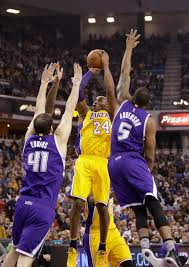

['men basketball to a during game the is a game the basketball is on court the court the game',
 'men basketball to a during game the is a game the basketball is on court the court the is',
 'men basketball to a during game the is a game the basketball is on court a court the is',
 'men basketball to a during game the is a game the basketball is on court a court a is',
 'men basketball to a during game the is a game the basketball is on court a court a play']

In [50]:
captions, generated, image_matrix = caption_image(finetuned_model, './kobe.jpeg')
captions

loading configuration file config.json from cache at C:\Users\folso\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k\snapshots\b4569560a39a0f1af58e3ddaf17facf20ab919b0\config.json
Model config ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "transformers_version": "4.51.3"
}

loading weights file model.safetensors from cache at C:\Users\folso\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k\snapshots\b4569560a39a0f1af58e3ddaf17facf20ab919b0\model.safetensors
All model checkpoint weights were used when initializing V

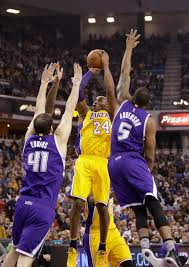

['.', '.', '.', '.', '.']

In [51]:
non_finetuned = VisionEncoderDecoderModel.from_encoder_decoder_pretrained('google/vit-base-patch16-224-in21k', 'distilgpt2')

captions, generated, image_matrix = caption_image(non_finetuned, './kobe.jpeg')
captions

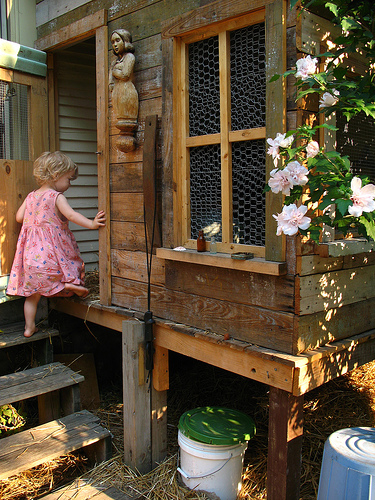

['children playing a in pond water a childs a outside a house a tree a house a house',
 'children playing a in pond water a childs a outside a house a tree a in garden trees',
 'children playing a in pond water a childs a outside a house a tree a in gardens',
 'children playing a in pond water a childs a outside a house a tree a in yard trees',
 'children playing a in pond water a childs a outside a house a tree a in yard garden']

In [ ]:
captions, generated, image_matrix = caption_image(
    finetuned_model, './flicker_images/1000268201_693b08cb0e.jpg'
)
captions

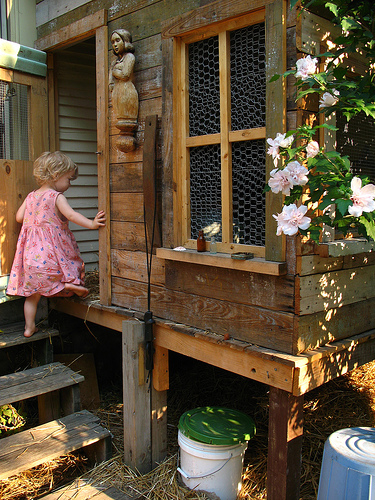

['.', '.', '.', '.\n\n\n\n\n\n\n“', '.']

In [53]:
captions, generated, image_matrix = caption_image(
    non_finetuned, './flicker_images/1000268201_693b08cb0e.jpg'
)
captions

In [55]:
!pip freeze

accelerate==1.6.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.18
aiosignal==1.3.2
asttokens @ file:///C:/b/abs_9662ywy9fp/croot/asttokens_1743630464377/work
attrs==25.3.0
certifi==2025.4.26
charset-normalizer==3.4.2
colorama @ file:///C:/Users/dev-admin/perseverance-python-buildout/croot/colorama_1699472650914/work
comm @ file:///C:/b/abs_67a8058udb/croot/comm_1709322909844/work
contourpy==1.3.2
cycler==0.12.1
datasets==3.6.0
debugpy @ file:///C:/b/abs_bf9oo2vhxp/croot/debugpy_1736269476451/work
decorator @ file:///opt/conda/conda-bld/decorator_1643638310831/work
dill==0.3.8
executing @ file:///opt/conda/conda-bld/executing_1646925071911/work
filelock==3.18.0
fonttools==4.58.0
frozenlist==1.6.0
fsspec==2025.3.0
huggingface-hub==0.31.2
idna==3.10
ipykernel @ file:///C:/b/abs_6c9ggygp01/croot/ipykernel_1737660720620/work
ipython @ file:///C:/b/abs_307wfft5yu/croot/ipython_1744912982439/work
ipython_pygments_lexers @ file:///C:/b/abs_b66hj1lo19/croot/ipython_pygments_lexers_1744753262043/work
j